## Linear regression

In [1]:
# libraries import
import pandas as pd
from rdkit import Chem
from rdkit.ML.Descriptors.Descriptors import DescriptorCalculator
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from catboost import CatBoostRegressor
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, FloatDistribution
import pickle
from sklearn.ensemble import RandomForestRegressor

#constants
RANDOM_STATE = 12345
CV = 5
DF_NAME = 'Condensation_reactions.xls'

In [2]:
# downloading the data
data = pd.read_excel(DF_NAME)
def SmilesCheck(smi:str) -> str or None:
    try:
        Chem.CanonSmiles(smi)
        return smi
    except:
        return None
index_to_drop = data[data['SMILES'].str.replace('>>', '.').apply(SmilesCheck).isna()].index
data.drop(index_to_drop, inplace=True)
data.shape

[08:39:17] Explicit valence for atom # 26 H, 2, is greater than permitted
[08:39:18] Explicit valence for atom # 26 H, 2, is greater than permitted
[08:39:19] Explicit valence for atom # 0 O, 3, is greater than permitted
[08:39:20] Explicit valence for atom # 10 O, 3, is greater than permitted


(1245, 4)

### Representation of molecules as RDKit descriptors

In [3]:
# downloading descriptors
descriptor_names = list(Chem.rdMolDescriptors.Properties.GetAvailableProperties())
descriptor_names.remove('exactmw')
print(len(descriptor_names))

42


*Descriptor list:*
- `amw` - molecular weight value rounded,
- `lipinskiHBA` - number of acceptors of H-bonds (according to Lipinski)
- `lipinskiHBD` - number of donors of H-bonds (according to Lipinski)
- `NumRotatableBonds` - returns the number of rotatable bonds for a molecule
- `NumHBD` - returns the number of H-bond donors for a molecule
- `NumHBA` - returns the number of H-bond acceptors for a molecule
- `NumHeavyAtoms` - returns the number of heavy atoms for a molecule
- `NumHeteroatoms` - calculates the number of heteroatoms
- `NumAmideBonds` - calculates the number of amide bonds
- `FractionCSP3` - calculates the fraction of carbons that are SP3 hybridized
- `NumRings` - calculates the number of SSSR rings ([Smallest Set of Smallest Rings](https://depth-first.com/articles/2020/08/31/a-smallest-set-of-smallest-rings/))
- `NumAromaticRings` - calculates the number of aromatic SSSR rings
- `NumAliphaticRings` - calculates the number of aliphatic (at least one non-aromatic bond) SSSR rings
- `NumSpiroAtoms` - calculates the number of spiro atoms (atoms shared between rings that share exactly one atom)
- `tpsa` - topological polar surface area [*paper*](https://pubs.acs.org/doi/full/10.1021/jm000942e)
- `CrippenClogP` and `CrippenCMR`- [*paper*](https://pubs.acs.org/doi/full/10.1021/ci990307l)
- `chi0v - chi4n`[*paper*](https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470125793.ch9)
- `hallKierAlpha` - Hall-Kier alpha value for a molecule From equation (58) of [*paper*](https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470125793.ch9)
- `Phi` - [Flexibiliry Index](https://onlinelibrary.wiley.com/doi/abs/10.1002/qsar.19890080307?casa_token=WnnfElJ7jz4AAAAA:zadQSetbkFxMz-lQY60PlFKhw6gR-bGNDdExpEp2dP3dfsO9aG16dVPYwh_UA2XXgJBb6f3q-1LNs6I)

In [4]:
# drscriptor calculation
def GetDescriptors(mol:Chem.MolFromSmiles) -> list:
    try:
        return list(get_descriptors.ComputeProperties(mol))
    except:
        return [None]*len(descriptor_names)
mols = data['SMILES'].str.replace('>>','.').apply(Chem.MolFromSmiles)
get_descriptors = Chem.rdMolDescriptors.Properties(descriptor_names)
descriptors = mols.apply(lambda x: GetDescriptors(x)).tolist()
descriptors = pd.DataFrame(descriptors, index = data.index, columns = descriptor_names)
descriptors['target'] = data['yield']

In [5]:
# Pearson's linear correlation between descriptors
corr = descriptors.copy().corr()
# we leave only descriptors that are not correlated with each other, we choose a threshold of 0.9
threshold = 0.9
for index in corr.index:
    corr.loc[index, index] = 0
descriptors_not_correlated = corr[(corr<=threshold)].dropna().index.tolist()
print('Number of descriptors left:', len(descriptors_not_correlated)-1)

Number of descriptors left: 13


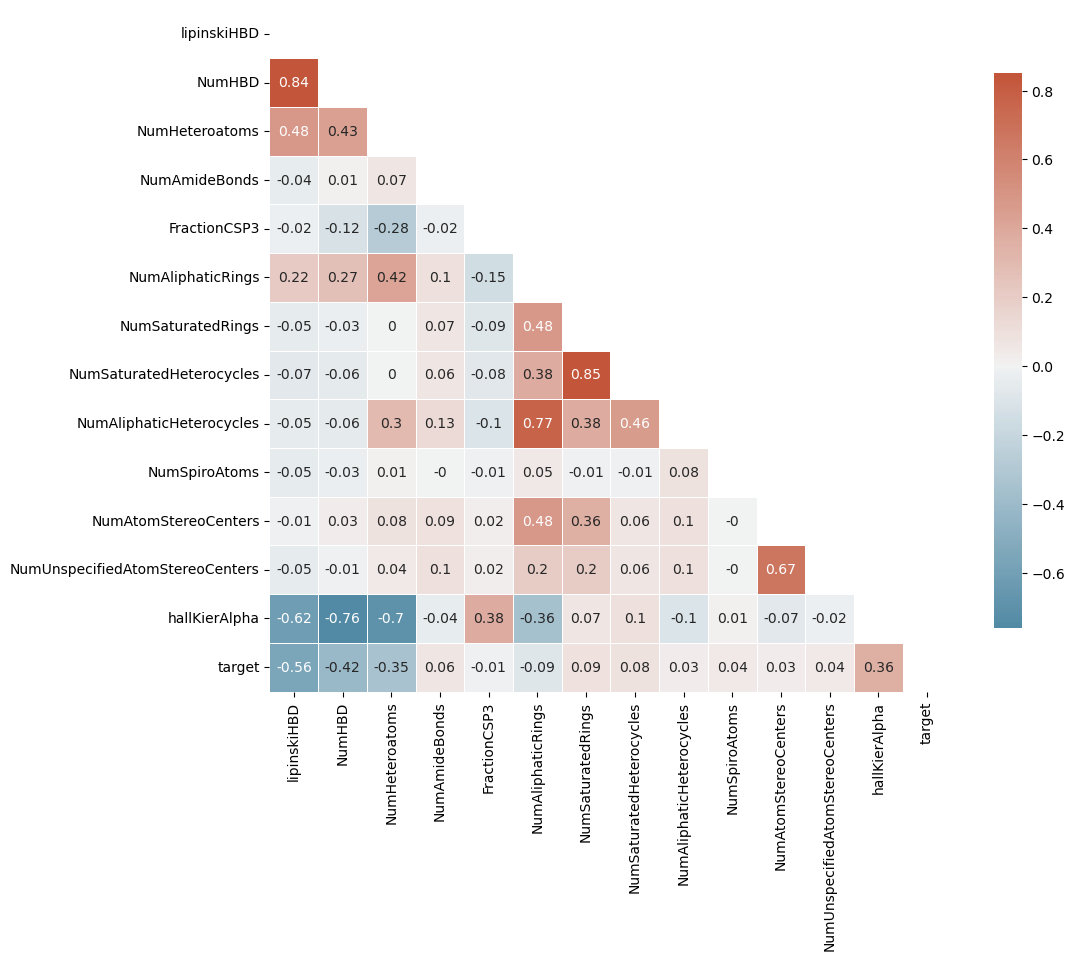

In [6]:
# correlation matrix
corr = round(descriptors.loc[:, descriptors_not_correlated].corr(),2)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.7, cbar_kws={"shrink": .8}, annot=True);

### Training of linear model

In [7]:
descriptors = descriptors.loc[:, descriptors_not_correlated]
features_train, features_test, target_train, target_test = train_test_split(descriptors.drop('target', axis=1),
                                                                            descriptors['target'],
                                                                            random_state=RANDOM_STATE,
                                                                            test_size=0.2)

# frame shapes
print('features_train, target_train:',features_train.shape, target_train.shape)
print('features_train, target_train:',features_test.shape, target_test.shape)

features_train, target_train: (996, 13) (996,)
features_train, target_train: (249, 13) (249,)


In [8]:
# linear regression with l2-regularization
pipe =  Pipeline([('scaler', StandardScaler()),
                  ('lr', Ridge(random_state=RANDOM_STATE))])

# l2-regularization coefficients
params = {'lr__alpha': np.arange(0, 50.5, 0.5)}

cv_model = RandomizedSearchCV(pipe,
                              params,
                              cv = CV,
                              n_iter=50,
                              scoring = ['neg_root_mean_squared_error', 'r2'],
                              refit = 'neg_root_mean_squared_error')
# training the model
cv_model.fit(features_train, target_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('lr',
                                              Ridge(random_state=12345))]),
                   n_iter=50,
                   param_distributions={'lr__alpha': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
       22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
       27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
       33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
       38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5,
       44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. ,
       49.5, 50. ])},
                   refit='neg_root_mean_squared_error',
                   scoring=['neg_root_mean_squared_error', 'r2'])

In [9]:
print('Best l2-regularization coefficient:', cv_model.best_params_)
print('RMSE (validation):', abs(round(cv_model.best_score_, 4)))
print('R2 (validation):', cv_model.cv_results_['mean_test_r2'][cv_model.best_index_].round(4))

Best l2-regularization coefficient: {'lr__alpha': 22.0}
RMSE (validation): 17.6489
R2 (validation): 0.3149


In [10]:
# descriptor contributions
features_coeff = {}
features_coeff['intercept'] = [cv_model.best_estimator_[1].intercept_]
for name, coeff in zip(cv_model.best_estimator_[0].feature_names_in_, cv_model.best_estimator_[1].coef_):
    features_coeff[name] = [coeff]
features_coeff = pd.DataFrame(features_coeff, index = ['coeff']).T
# sorting
index_sorted = abs(features_coeff['coeff']).sort_values(ascending=False).index
display(features_coeff.loc[index_sorted])
features_coeff.loc[index_sorted].to_excel('descriptors_coeff.xlsx', index=True)

,coeff
intercept,31.730060
lipinskiHBD,-12.104104
NumHeteroatoms,-3.022523
NumSaturatedRings,2.320799
NumHBD,2.213919
NumAtomStereoCenters,-1.140916
NumSaturatedHeterocycles,-1.070901
NumUnspecifiedAtomStereoCenters,0.750002
FractionCSP3,-0.713060
NumAmideBonds,0.626306


### Validation

In [11]:
# lr with l2-regularization
pipe =  Pipeline([('scaler', StandardScaler()),
                  ('lr', Ridge(random_state=RANDOM_STATE, alpha = 22.5))])

In [12]:
# train-test split taking into account coefficients in products
def split_ind(data:pd.DataFrame, ind:pd.Series, ran_state:int):
    ind_unique = ind.unique()
    ind_train, ind_test = train_test_split(ind_unique,
                                       test_size=0.2,
                                       random_state=ran_state*7+10)
    
    data_train = data.loc[data['ind'].isin(ind_train)]
    data_test = data.loc[data['ind'].isin(ind_test)]
    
    features_train, target_train = data_train.drop('target', axis=1), data_train['target']
    features_test, target_test = data_test.drop('target', axis=1), data_test['target']

    assert features_train.shape[0] == target_train.shape[0]
    assert features_test.shape[0] == target_test.shape[0]
    assert features_train.shape[1] == features_test.shape[1]

    return features_train, features_test, target_train, target_test

# metrics
def metrics_get(target_test, predictions) -> list:
    return [mean_squared_error(target_test, predictions),
            mean_squared_error(target_test, predictions, squared=False),
            mean_absolute_error(target_test, predictions),
            r2_score(target_test, predictions)]

In [13]:
# random splitting (10 times)
iterations = {}
for i in range(10):
    features_train, features_test, target_train, target_test = train_test_split(descriptors.drop('target', axis=1),
                                                                                descriptors['target'],
                                                                                random_state=i*5+10,
                                                                                test_size=0.2)
    assert features_train.shape[0] == target_train.shape[0]
    assert features_test.shape[0] == target_test.shape[0]
    assert features_train.shape[1] == features_test.shape[1]
    
    # training the model
    pipe.fit(features_train, target_train)
    predictions = pipe.predict(features_test)
    iterations[i] = metrics_get(target_test, predictions)
    
    result = pd.DataFrame(iterations, index = ['MSE', 'RMSE', 'MAE', 'R2']).T
    
    result.loc['mean',:] = result.mean()
    result.loc['std',:] = result.std()

    result.to_excel('result_random.xlsx', index=True)

In [14]:
# train-test split taking into account coefficients in products
iterations = {}
descriptors['ind'] = data['Ind']

for i in range(10):
    features_train, features_test, target_train, target_test = split_ind(descriptors, descriptors['ind'], i)
    
    # обучение модели
    pipe.fit(features_train, target_train)
    predictions = pipe.predict(features_test)
    iterations[i] = metrics_get(target_test, predictions)
    
result = pd.DataFrame(iterations, index = ['MSE', 'RMSE', 'MAE', 'R2']).T
    
result.loc['mean',:] = result.mean()
result.loc['std',:] = result.std()

result.to_excel('result.xlsx', index=True)